# Double Deep Q Learning Model + Experience Replay 

## Job/Pod model :

Job has the following characteristics :  
- working time = Tw
- repititon period = Tp
- RAM consumption = Um


define 6 Jobs with the following formula :


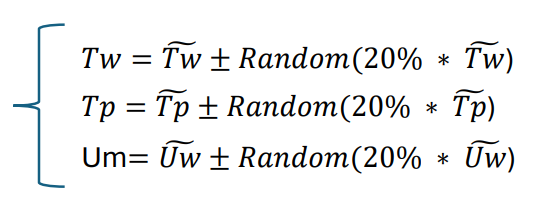

## 1- Define Imports

In [1]:
import tensorflow as tf

# Get the list of physical devices
tf.config.list_physical_devices('GPU')



[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
# Check if GPU is available
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("No GPU available. TensorFlow will use CPU.")

Default GPU Device: /device:GPU:0


In [5]:
import matplotlib.pyplot as plt
import logging

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from collections import deque, namedtuple
import numpy as np
import random


## 2- Cluster simulation :

In [4]:

class Pod:
    def __init__(self, tw_mean=35, tp_mean=50, um_mean=0.5, duration=200, start_time=0, variability=0.4):
        self.tw_mean = tw_mean  # Average active time
        self.tp_mean = tp_mean  # Period of repetition
        self.um_mean = um_mean  # Utilization mean
        self.duration = duration  # Total duration to simulate
        self.start_time = start_time
        self.variability = variability  # Variability as a fraction of the parameter
        self.activity = self.generate_activity()

    
    def generate_activity(self):
        with tf.device('/GPU:0'):
            up_time = self.duration - self.start_time
            time = np.linspace(0, up_time, num=int(up_time))
            activity = np.zeros_like(time)
    
            for period_start in np.arange(0, up_time, self.tp_mean):
                # Apply the random variation based on the formula provided
                tw_variation = random.uniform(-1, 1) * self.variability * self.tw_mean
                tp_variation = random.uniform(-1, 1) * self.variability * self.tp_mean
                um_variation = random.uniform(-1, 1) * self.variability * self.um_mean
    
                tw = self.tw_mean + tw_variation
                tp = self.tp_mean + tp_variation
                um = self.um_mean + um_variation
    
                period_end = period_start + tw
                rising_end = period_start + tw * 0.2  # Adjust this value for rising duration
                falling_start = period_end - tw * 0.2  # Adjust this value for falling duration
                end = min(period_end, up_time)
    
                # Rising phase
                rising_indices = np.where((time >= period_start) & (time < rising_end))[0]
                rising_time = time[rising_indices] - period_start
                rising_activity = rising_time / np.max(rising_time)
    
                activity[rising_indices] = rising_activity
    
                # Falling phase
                falling_indices = np.where((time >= falling_start) & (time < end))[0]
                if falling_indices.size > 0:  # Check if falling_indices is not empty
                    falling_time = time[falling_indices] - falling_start
                    falling_activity = 1 - falling_time / np.max(falling_time)
                    activity[falling_indices] = falling_activity
    
            # Normalize the activity to the utilization mean
            activity *= um / np.max(activity)
            
            # Empty activity head
            empty_activity = [0] * self.start_time
            if len(empty_activity) != 0:
                total_activity = empty_activity + list(activity)
                return total_activity
            else:
                return activity






In [5]:

class Node:
    def __init__(self, index, memory_capacity, duration):
        self.index = index
        self.memory_capacity = memory_capacity
        self.pods = []
        self.total_utilization = tf.zeros(duration, dtype=tf.float32)

    def get_pod_uuids(self):
        """Return a list of UUIDs of all pods on this node."""
        return [pod.uuid for pod in self.pods]

    def add_pod(self, pod, step=0):
        with tf.device('/GPU:0'):
            self.pods.append(pod)
            pod_activity = tf.constant(pod.activity[step:], dtype=tf.float32)
            
            if tf.size(self.total_utilization) == 0:
                self.total_utilization = pod_activity
            else:
                updated_utilization = tf.concat(
                    [self.total_utilization[:step], self.total_utilization[step:] + pod_activity], axis=0
                )
                self.total_utilization = updated_utilization

    def remove_pod(self, pod, step=0):
        with tf.device('/GPU:0'):
            self.pods.remove(pod)
            pod_activity = tf.constant(pod.activity[step:], dtype=tf.float32)
            updated_utilization = tf.concat(
                [self.total_utilization[:step], self.total_utilization[step:] - pod_activity], axis=0
            )
            self.total_utilization = updated_utilization

    def print_total_utilization(self):
        num_steps = len(self.total_utilization)

        plt.figure(figsize=(10, 6))
        plt.plot(range(num_steps), self.total_utilization.numpy(), color='red')
        plt.xlabel('Time Step')
        plt.ylabel('Utilization')
        plt.title('Total Utilization')
        plt.grid()
        plt.show()

    def find_min_pod_to_relieve_overload(self, step, threshold=0.8):
        with tf.device('/GPU:0'):
            current_utilization = self.total_utilization[step].numpy() if step < len(self.total_utilization) else 0
    
            possible_pods = []
            for pod in self.pods:
                simulated_utilization = current_utilization - pod.activity[step]
                if simulated_utilization < threshold:
                    possible_pods.append(pod)
    
            if not possible_pods:
                print(f"No single pod on node {self.index} can relieve the overload by itself.")
                return None
    
            min_utilization_pod = min(possible_pods, key=lambda pod: pod.um_mean)
            return min_utilization_pod


### reward functions :

In [6]:
import tensorflow as tf

# Parameters
a = 0.2    # Penalty for deviation from the target memory usage
b = 0.1    # Penalty for changes in memory usage
c = 2      # Reward for beneficial minimal changes
threshold = 0.8   # Memory usage threshold as a decimal
y = 0.5     # Weighting factor between continuous and discrete reward components


def continuous_reward(old_usages, new_usages, target_memory_usage):
    with tf.device('/GPU:0'):
        old_usages = tf.constant(old_usages, dtype=tf.float32)
        new_usages = tf.constant(new_usages, dtype=tf.float32)
        target_memory_usage = tf.constant(target_memory_usage, dtype=tf.float32)
    
        deviation_penalty = a * tf.reduce_sum((new_usages - target_memory_usage)**2)
        change_penalty = b * tf.reduce_sum((new_usages - old_usages)**2)
        
        deviation_condition = tf.reduce_all(tf.abs(new_usages - target_memory_usage) <= 0.05)
        change_condition = tf.reduce_all(tf.abs(new_usages - old_usages) <= 0.05)
        
        if deviation_condition and change_condition:
            return -deviation_penalty - change_penalty + c
        return -deviation_penalty - change_penalty

# Discrete Reward Component

def discrete_reward(old_usages, new_usages, threshold):
    with tf.device('/GPU:0'):
        old_usages = tf.constant(old_usages, dtype=tf.float32)
        new_usages = tf.constant(new_usages, dtype=tf.float32)
        threshold = tf.constant(threshold, dtype=tf.float32)
    
        exceedances_condition = tf.reduce_any(new_usages > threshold)
        exceedances = new_usages[new_usages > threshold]
        
        reward = tf.cond(
            exceedances_condition,
            lambda: -10 * tf.reduce_sum((exceedances - threshold) / threshold),
            lambda: tf.cond(
                tf.reduce_all(new_usages == old_usages),
                lambda: tf.constant(1, dtype=tf.float32),
                lambda: tf.constant(0, dtype=tf.float32)
            )
        )
        return reward


In [7]:

def check_over_capacity(node, pod_activity, step, threshold=1):
    with tf.device('/GPU:0'):
        """Check if adding the pod will exceed the node's capacity for any time step."""
        total_utilization = tf.constant(node.total_utilization[step:].numpy(), dtype=tf.float32)
        pod_activity = tf.constant(pod_activity[step:], dtype=tf.float32)
        threshold = tf.constant(threshold, dtype=tf.float32)
    
        exceeded = tf.reduce_any(total_utilization + pod_activity >= threshold)
    
        if exceeded:
            # exceedance_indices = tf.where(total_utilization + pod_activity > threshold)
            # first_exceedance_step = exceedance_indices[0][0].numpy() + step
            # print(f"Adding pod will exceed capacity at step {first_exceedance_step}")
            return True
        return False



In [8]:

class Cluster:
    def __init__(self, node_memories, duration):
        self.nodes = [Node(index, node_memory, duration=duration) for index, node_memory in enumerate(node_memories)]

    def map_action_space(self):
        with tf.device('/GPU:0'):
            action_space = {}
            action_space[0] = (-1, -1)  # this action indicates that we do nothing
            index = 0
    
            for i, node_from in enumerate(self.nodes):
                for j, node_to in enumerate(self.nodes):
                    if i != j:
                        action_space[index + 1] = (node_from.index, node_to.index)
                        index += 1
    
            return action_space

    def find_current_node(self, pod_uuid):
        with tf.device('/GPU:0'):
            for node in self.nodes:
                for pod in node.pods:
                    if pod.uuid == pod_uuid:
                        return node
            logging.error("Pod not found in any node.")
            return None

    def simulate_step(self, action_index, step):
        with tf.device('/GPU:0'):
            action_space_dict = self.map_action_space()
            from_node, to_node = action_space_dict[action_index]
            print('this is the action you chose: ', from_node, " -> ", to_node)
    
            print("fetching current state...\n")
            print("the step is : ", step)
            old_usage = self.get_state(step)
            print("current state is : ", old_usage)
    
            # Do nothing
            if to_node == -1:
                reward = self.calculate_reward(old_usage, old_usage)
                print("reward calculated : ", reward)
                return old_usage, reward, False
    
            # else attempt to reschedule
            return self.attempt_reschedule(from_node, to_node, old_usage, step)

    def attempt_reschedule(self, from_node, to_node, old_usage, step, threshold=1):
        with tf.device('/GPU:0'):
            print("attempting to reschedule...looking for pods...")
            pod = self.nodes[from_node].find_min_pod_to_relieve_overload(step)
            if pod is None:
                reward = self.calculate_reward(old_usage, old_usage)
                return old_usage, reward, True
    
            print("pod found and mean Um of pod is : ", pod.um_mean)
            print("fetching target node")
            target_node = self.nodes[to_node]
    
            # rescheduling failed
            if check_over_capacity(target_node, pod.activity, step + 1):
                print("Rescheduling would overload the node: Node {} would exceed the allowed utilization threshold.".format(target_node.index))
                reward = self.calculate_reward(old_usage, old_usage)
                return old_usage, reward, True
    
            # reschedule succeeds
            print("removing pod from old node...")
            self.nodes[from_node].remove_pod(pod, step + 1)
            print("now adding to new node...")
            target_node.add_pod(pod, step + 1)
            print("fetching new state...")
            new_usage = self.get_state(step + 1)
    
            reward = self.calculate_reward(old_usage, new_usage)
    
            next_state = self.get_state(step + 1)
            return next_state, reward, False

    def get_state(self, step):
        with tf.device('/GPU:0'):
            state = []
            for node in self.nodes:
                state.append(node.total_utilization[step])
            return np.array(state)

    def calculate_reward(self, old_usages, new_usages, target_memory_usage=0.55, threshold=0.8, y=0.5):
        with tf.device('/GPU:0'):
            old_usages = tf.constant(old_usages, dtype=tf.float32)
            new_usages = tf.constant(new_usages, dtype=tf.float32)
            target_memory_usage = tf.constant(target_memory_usage, dtype=tf.float32)
            threshold = tf.constant(threshold, dtype=tf.float32)
    
            Rcont = continuous_reward(old_usages, new_usages, target_memory_usage)
            Rdisc = discrete_reward(old_usages, new_usages, threshold)
            return y * Rcont + (1 - y) * Rdisc





## 3- Training enviroment :

### 3.1- Agent class

In [9]:

class MemoryOptimizationAgent:
    def __init__(self, state_size, action_size, epsilon=1, epsilon_decay=0.998, epsilon_end=0.01, gamma=0.99, update_target_every=1000):
        self.state_size = state_size
        self.action_size = action_size
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_end = epsilon_end
        self.gamma = gamma

        self.q_model = self.build_model()  # Q-network
        self.target_model = self.build_model()  # Target network

        self.update_target_every = update_target_every
        self.steps_since_last_target_update = 0

    def build_model(self):
        model = Sequential([
            Dense(64, activation='relu', input_shape=(self.state_size,)),
            Dense(64, activation='relu'),
            Dense(32, activation='relu'),
            Dense(self.action_size, activation='linear')
        ])
        model.compile(optimizer='adam', loss='mse')
        return model

    def update_target_model(self):
        with tf.device('/GPU:0'):
            self.target_model.set_weights(self.q_model.get_weights())

    def get_action(self, state):
        with tf.device('/GPU:0'):
            if np.random.rand() <= self.epsilon:
                # Random action: choose a random pod and node
                action_index = np.random.randint(0, self.action_size)
            else:
                # Predicted action: choose the best action based on the NN's output
                state_tensor = tf.convert_to_tensor(state[np.newaxis], dtype=tf.float32)
                q_values = self.q_model.predict(state_tensor)
                action_index = np.argmax(q_values[0])

            # Update epsilon
            if self.epsilon > self.epsilon_end:
                self.epsilon *= self.epsilon_decay
            else:
                self.epsilon = self.epsilon_end

        return action_index

    def learn(self, experiences):
        with tf.device('/GPU:0'):
            states = tf.convert_to_tensor([experience.state for experience in experiences], dtype=tf.float32)
            actions = tf.convert_to_tensor([experience.action for experience in experiences], dtype=tf.int32)
            rewards = tf.convert_to_tensor([experience.reward for experience in experiences], dtype=tf.float32)
            next_states = tf.convert_to_tensor([experience.next_state for experience in experiences], dtype=tf.float32)
            dones = tf.convert_to_tensor([experience.done for experience in experiences], dtype=tf.float32)

            current_q_values = self.q_model.predict(states)
            next_q_values = self.target_model.predict(next_states)

            target_q_values = current_q_values  
            for i in range(len(experiences)):
                if dones[i]:
                    target_q_values[i, actions[i]] = rewards[i]
                else:
                    target_q_values[i, actions[i]] = rewards[i] + self.gamma * np.max(next_q_values[i])

            # Convert back to TensorFlow tensor for training
            target_q_values = tf.convert_to_tensor(target_q_values, dtype=tf.float32)

            self.q_model.fit(states, target_q_values, epochs=1, verbose=0)
            
        self.steps_since_last_target_update += 1
        if self.steps_since_last_target_update >= self.update_target_every:
            self.update_target_model()
            self.steps_since_last_target_update = 0

    def load(self, file_path):
        self.q_model = tf.keras.models.load_model(file_path)

    def save(self, file_path):
        self.q_model.save(file_path)




### 3.2- Experience replay

In [10]:
class ExperienceReplay:
    def __init__(self, capacity, batch_size):
        self.memory = deque(maxlen=capacity)
        self.batch_size = batch_size
        self.Experience = namedtuple('Experience', ['state', 'action', 'reward', 'next_state', 'done'])

    def add_experience(self, state, action, reward, next_state, done):
        experience = self.Experience(state, action, reward, next_state, done)
        self.memory.append(experience)

    def sample_batch(self):
        with tf.device('/GPU:0'):
            batch = random.sample(self.memory, self.batch_size)
            return batch

    def can_provide_sample(self):
        return len(self.memory) >= self.batch_size


### 3.3- Environment class

In [11]:
# every scenario is a list of 3 sublists for each node
# every sublist contaisn tuples containing a pod's charactersitics
# pods charactersitics are in the following order : tw_mean, tp_mean, um_mean, start_time
scenario_dict ={
    1 : [
        [(35, 50, 0.55, 0), (20, 40, 0.45, 15)],
        [(30, 50, 0.1, 10), (18, 28, 0.2, 20)],
        [(20, 30, 0.1, 0), (40, 50, 0.2, 20)]
    ],
    2 : [
        [(35, 50, 0.51, 0), (20, 30, 0.30, 15), (25, 40, 0.28, 25)],
        [(18, 25, 0.2, 20)],
        [(20, 35, 0.15, 0), (40, 50, 0.1, 20)]
    ],
    3 : [
        [(35, 50, 0.67, 0), (30, 45, 0.37, 15)],
        [(25, 50, 0.2, 10), (20, 40, 0.25, 20)],
        [(20, 35, 0.15, 0), (38, 55, 0.2, 20)]
    ],
    4 : [
        [(35, 50, 0.50, 0), (28, 40, 0.24, 15), (30, 40, 0.39, 25)],
        [(18, 25, 0.3, 20)],
        [(20, 25, 0.15, 0), (40, 50, 0.2, 20)]
    ]
}

In [12]:


class KubernetesEnvironment:
    def __init__(self, num_nodes=3, num_pods=6, node_capacities=[1, 1, 1], pod_threshold=80, max_pod_memory=50):
        self.num_nodes = num_nodes
        self.num_pods = num_pods
        self.cluster = None
        self.node_capacities = node_capacities
        self.pods = []
    # @cuda.jit()
    def reset(self, max_steps):
        with tf.device('/GPU:0'):
            self.cluster = Cluster(node_memories=self.node_capacities, duration=max_steps)
            random_scenario_number = random.randint(1, 4)
            scenario = scenario_dict[random_scenario_number]
            numbers = [0, 1, 2]
            random.shuffle(numbers)
            for i, list_pods in enumerate(scenario):
                for pod_char in list_pods:
                    tw_mean, tp_mean, um_mean, start_time = pod_char
                    self.cluster.nodes[numbers[i]].add_pod(Pod(tw_mean=tw_mean, tp_mean=tp_mean, um_mean=um_mean, duration=max_steps, start_time=start_time))
            return self.cluster

    def get_state(self, step):
        return self.cluster.get_state(step)

    def execute_action(self, action_index, step):
        with tf.device('/GPU:0'):
            return self.cluster.simulate_step(action_index, step)



# main class

In [15]:
import pickle

def save_agent_data(agent, reward_list,average_reward_list, episode_count, filepath_prefix):
    filepath = f'{filepath_prefix}_{episode_count}_ep_epsilone_rewardlist.pkl'
    data = {
        'epsilon': agent.epsilon,
        'reward_list': reward_list,
        'average_reward_list': average_reward_list,
        'steps_since_last_target_update': agent.steps_since_last_target_update
    }
    with open(filepath, 'wb') as f:
        pickle.dump(data, f)

In [16]:
def convert_to_numpy(experience):
    state = np.array(experience.state)
    action = experience.action
    reward = np.array(experience.reward)
    next_state = np.array(experience.next_state)
    done = experience.done
    return (state, action, reward, next_state, done)

In [ ]:

if __name__ == '__main__':
    environment = KubernetesEnvironment()
    agent = MemoryOptimizationAgent(state_size=3, action_size=7, epsilon=1, epsilon_decay=0.998, epsilon_end=0.01)
    experience_replay = ExperienceReplay(capacity=400000, batch_size=32)
    episodes = 700
    max_steps = 400
    reward_list = []
    average_reward_list =[]

    # Path to the log file in the current directory
    log_file_path = 'logs.txt'

    # Open the log file
    with open(log_file_path, 'a') as log_file:
        for episode in range(episodes):
            average_temp = []
            cluster = environment.reset(max_steps+1)
            space = cluster.map_action_space()
            print(space)
            state = environment.get_state(0)
            cumulative_reward = 0
            for step in range(max_steps):
                log_message = f'Episode: {episode}, Step: {step}, Epsilon: {agent.epsilon}\n'
                print(log_message)
                log_file.write(log_message)

                action = agent.get_action(state)
                next_state, reward, done = environment.execute_action(action, step)
                cumulative_reward += reward
                average_temp.append(reward)
                print("cumulative_reward: ", cumulative_reward)

                experience_replay.add_experience(state, action, reward, next_state, done)
                if experience_replay.can_provide_sample() and (step % 4 == 0) :
                    experiences = experience_replay.sample_batch()
                    agent.learn(experiences)

                state = next_state

                if done:
                    break
                time.sleep(0.05)
            
            average_reward_list.append(sum(average_temp)/len(average_temp))
            # Log cumulative reward for the episode
            # print("reward list before:", reward_list)
            reward_list.append(cumulative_reward)
            # print("reward list after:", reward_list)
            log_message = f'Episode {episode} Cumulative Reward: {cumulative_reward}\n'
            print(log_message)
            log_file.write(log_message)
            
            # Save the model every 100 episodes
            if (episode + 1) % 100 == 0:
                model_name = f'model_{episode + 1}.h5'
                agent.save(model_name)
                target_model_name = f'target_model_{episode + 1}.h5'
                agent.target_model.save(target_model_name)
                save_agent_data(agent, reward_list, average_reward_list, episode_count= episode + 1, filepath_prefix='agent_data')
                # Convert memory to list of tuples with numpy arrays
                memory_as_tuples = [convert_to_numpy(exp) for exp in experience_replay.memory]
                # Save the converted memory with the episode count appended to the file name
                with open(f'experience_memory_{episode+1}_ep.pkl', 'wb') as f:
                    pickle.dump(memory_as_tuples, f)

       
